In [3]:
%load_ext autoreload
%autoreload 2

import h5py
import numpy as np
import random
import requests
import tempfile
from PIL import Image

from src.data_management.election_image_storage import ElectionImageStorage

import sys
sys.path.append('./src/llm_model/')

# Importa tu handler personalizado aquí
from src.llm_model.scrutari_ocularis_model import ScrutariOcularisModel

from PIL import Image
import io
import torch
import os
import logging

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:



# Ruta al archivo HDF5 con las imágenes y votos
hdf5_path = 'processed_images.hdf5'

# Abrir el archivo HDF5 para lectura
with h5py.File(hdf5_path, 'r') as hdf5_file:
    # Listar todos los grupos (nombres de archivo) del archivo HDF5
    keys = list(hdf5_file.keys())
    # Seleccionar una clave al azar para un grupo
    random_key = random.choice(keys)
    # Acceder al grupo seleccionado
    group = hdf5_file[random_key]
    # Buscar dentro del grupo un dataset que termine en '_image'
    for item in group.keys():
        if item.endswith('_image'):
            image_data = group[item][()]
            # El valor votado está almacenado como un atributo que comparte el prefijo con la imagen
            voted_value = group.attrs[item.replace('_image', '_votos')]
            break

print(f"hdf5_path requests: {hdf5_path}")

# Guardar la imagen en un archivo temporal
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as temp_image_file:
    image = Image.fromarray(image_data)
    image.save(temp_image_file)
    temp_image_file_path = temp_image_file.name


print(f"Imagen requests: {temp_image_file_path}")


hdf5_path requests: processed_images.hdf5
Imagen requests: C:\Users\nicoc\AppData\Local\Temp\tmppx6ocw50.png


In [21]:

from scrutari_ocularis__model_utils import ScrutariOcularisModelUtils

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Ruta al archivo HDF5 con las imágenes y votos
hdf5_path = 'processed_images.hdf5'

use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()
print(f"use_cuda model {use_cuda}")
print(f"use_mps model {use_mps}")

logger = logging.getLogger(__name__)

device = None

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    print("USING CPU")

model = ScrutariOcularisModel().to(device) 

name_file_model = "./models/scrutari_ocularis_model_v_1.pt"

if os.path.exists(name_file_model):
    if use_cuda:
        model.load_state_dict(torch.load(name_file_model))
    else:
        model.load_state_dict(torch.load(name_file_model, map_location=device))
    print("Save model")
else:
    print("No se encontró un modelo previo.")

model.eval()

# Convertir la imagen en un objeto de imagen PIL
image = Image.fromarray(image_data)

# Simular una solicitud HTTP convirtiendo la imagen PIL a bytes y luego a un objeto bytearray
buffered = io.BytesIO()
image.save(buffered, format="PNG")
image_bytes = bytearray(buffered.getvalue())

# Llamar al método preprocess del handler con los datos de la imagen
# En este caso, simulamos una lista de diccionarios con claves 'body' que TorchServe pasaría
preprocessed_data = ScrutariOcularisModelUtils.preprocess(logger, [{'body': image_bytes}])

# Simular una inferencia llamando al método inference del handler
# Necesitarías asegurarte de que tu modelo está cargado correctamente para esto
inference_result = ScrutariOcularisModelUtils.inference(model, preprocessed_data)

# Llamar al método postprocess para obtener la respuesta final
postprocessed_result = ScrutariOcularisModelUtils.postprocess(inference_result)

print(f"Imagen seleccionada: {random_key}")
print(f"Valor votado: {voted_value}")
print(f"Valor predicho: {postprocessed_result}")

use_cuda model False
use_mps model False
USING CPU
Save model
Imagen seleccionada: 0100301168X
Valor votado: 70.0
Valor predicho: [108]


In [27]:
import base64

# Configura la URL del servidor de PyTorch Serve
serve_url = "http://localhost:8000/process-image"

# Convertir la imagen en un objeto de imagen PIL
image = Image.fromarray(image_data)

# Simular una solicitud HTTP convirtiendo la imagen PIL a bytes y luego a un objeto bytearray
buffered = io.BytesIO()
image.save(buffered, format="PNG")
image_base64 = base64.b64encode(buffered.getvalue()).decode('utf-8')

# Enviar la imagen al servidor de PyTorch Serve y recibir la predicción
serve_url = "http://localhost:8000/process-image"
response = requests.post(serve_url, json={"data": image_base64})
    
# Comparar la predicción con el valor votado
predicted_value = response.text
print(f"Imagen seleccionada: {random_key}")
print(f"Valor votado: {voted_value}")
print(f"Valor predicho: {predicted_value}")


Imagen seleccionada: 0100301168X
Valor votado: 70.0
Valor predicho: {"message":[108]}


In [28]:
!pip install boto3


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\nicoc\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [12]:
import boto3
import os
import random
import matplotlib.pyplot as plt
from botocore.exceptions import ClientError


In [11]:

# Configura tus credenciales y endpoint de MinIO aquí
ACCESS_KEY = 'ilF2NsVI6vwbYc052vbG'
SECRET_KEY = 'wRZY91TKq3Mr7I0YKPyRAQODR05fJgkwHTiUE4bX'
ENDPOINT_URL = 'http://localhost:9000'
BUCKET_NAME = 'ballotage'

# Configura la carpeta local de donde se cargarán las imágenes
FOLDER = "./files-examples/ballotage/"

In [14]:
import boto3

# Configuración del cliente de S3
s3_client = boto3.client('s3',
                         endpoint_url=ENDPOINT_URL,
                         aws_access_key_id=ACCESS_KEY,
                         aws_secret_access_key=SECRET_KEY)

# Método para descargar archivos de S3 a memoria
def download_file_to_memory(bucket_name, key):
    try:
        response = s3_client.get_object(Bucket=bucket_name, Key=key)
        return response['Body'].read()
    except ClientError as e:
        print(f"No se pudo descargar el archivo: {e}")
        return None

response: [{"path":"telegramas/celdas/mock_telegrama_0_celda_0.png","predicted":[180]}]


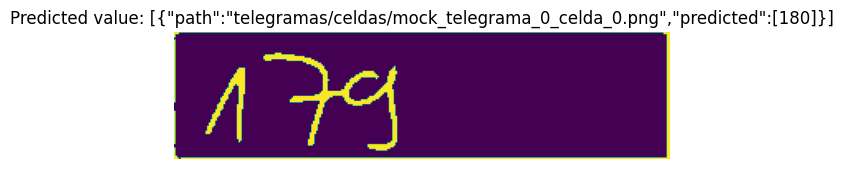

In [19]:

# Configura la URL del servidor de PyTorch Serve
serve_url = "http://localhost:8000/process-image-s3"

path = "telegramas/celdas/mock_telegrama_0_celda_0.png"

# Enviar la imagen al servidor de PyTorch Serve y recibir la predicción
response = requests.post(serve_url, json={"paths": [path]})

# Comparar la predicción con el valor votado
predicted_value = response.text
print(f"response: {response.text}")

celdas_test = download_file_to_memory(BUCKET_NAME, path)

# Convertir los bytes a un objeto Image
image = Image.open(io.BytesIO(celdas_test))

# Mostrar la imagen con Matplotlib
plt.imshow(image)
plt.title(f"Predicted value: {predicted_value}")
plt.axis('off')  # No mostrar los ejes
plt.show()